In [1]:
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import time

from quantnn.qrnn import QRNN
from quantnn.models.pytorch.xception import XceptionFpn

import sys
sys.path.append('../src/')
from load_data import GOESRETRIEVALSDataset, Mask, RandomSmallVals, RandomCrop, Standardize, ToTensor

In [2]:
f = open('../path_to_data.txt', "r")
path_to_data = os.path.join(f.readline().rstrip("\n"),'data')
f.close() 

In [3]:
xception = QRNN.load('../results/xception64_[100]_0.01__boxes_100_0.01_0_t5412_v1354[0, 1, 2, 3, 4, 5, 6, 7]_Adam_1622288705.386947.pckl') #xception.pckl')

In [4]:
def importData(BATCH_SIZE, path_to_data, path_to_stats, channel_inds, isTrain=False):

    transforms_list = [Mask(), RandomSmallVals()]
    if isTrain:
        transforms_list.append(RandomCrop(128))
    transforms_list.extend([Standardize(path_to_stats, channel_inds), ToTensor()])

    dataset = GOESRETRIEVALSDataset(
        path_to_data=path_to_data, 
        channel_inds=channel_inds,
        transform=transforms.Compose(transforms_list))
    print('number of samples:', len(dataset))

    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    return(dataset, dataloader)

In [5]:
BATCH_SIZE = 64 

In [6]:
channel_inds = list(range(0,8))

keys=("box", "label")

path_to_stats = os.path.join(path_to_data, 'stats.npy')
path_to_test_data_files = os.path.join(path_to_data,'dataset-boxes', 'test', 'npy_files')

test_dataset, test_data = importData(BATCH_SIZE, path_to_test_data_files, path_to_stats, channel_inds)


number of samples: 2928


In [7]:
start = time.time()

y_true_tot = []
y_pred_tot = []
crps_tot = []

with torch.no_grad():
    for batch_index, batch_data in enumerate(test_data):
        print(batch_index)
        
        boxes = batch_data['box']
        y_true = batch_data['label']
        
        mask = (torch.less(y_true, 0))
        
        y_pred = xception.posterior_mean(boxes)
        crps = xception.crps(x=boxes, y_true=y_true)
        
        y_true_tot += [y_true[~mask].detach().numpy()]
        y_pred_tot += [y_pred[~mask].detach().numpy()]
        crps_tot += [crps[~mask].detach().numpy()]
        
end = time.time()
print('time:', end-start)

0


/export/home/ingrid/anaconda3/envs/geo/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
time: 5661.7409682273865


In [ ]:
y_true_tot_c = np.concatenate(y_true_tot, axis=0)
y_pred_tot_c = np.concatenate(y_pred_tot, axis=0)
crps_tot_c = np.concatenate(crps_tot, axis=0)

In [14]:
bins = np.logspace(-2, 2, 81)
freqs, _, _ = np.histogram2d(y_true_tot_c, y_pred_tot_c, bins=bins)

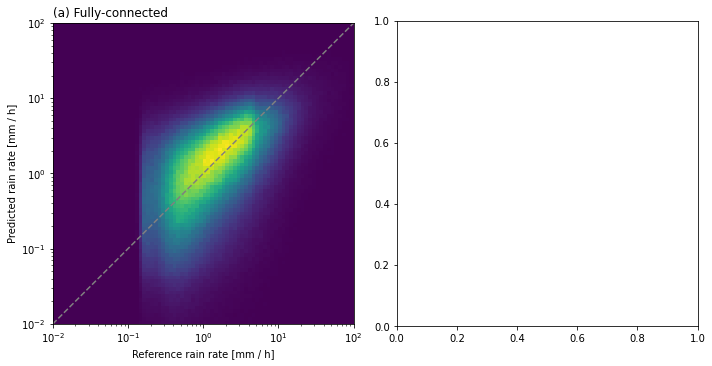

In [15]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
#norm = Normalize(0, 400)

f, axs = plt.subplots(1, 2, figsize=(10, 5))

ax = axs[0]
ax.pcolormesh(bins, bins, freqs.T)#, norm=norm)
ax.set_xlim([1e-2, 1e2])
ax.set_ylim([1e-2, 1e2])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Reference rain rate [mm / h]")
ax.set_ylabel("Predicted rain rate [mm / h]")
ax.set_title("(a) Fully-connected", loc="left")
ax.plot(bins, bins, c="grey", ls="--")
ax.set_aspect(1.0)

plt.tight_layout()